In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
gym_df = pd.read_csv('../data/gym_churn.csv')
gym_df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [78]:
from sklearn.model_selection import train_test_split

# 데이터 준비
X = gym_df[['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Contract_period', 'Group_visits', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']] # 'Phone' 제외
y = gym_df['Churn']

print(X.shape, y.shape) # (4000, 12) (4000,)
print('-----------------------')
print(len(X.columns)) # 12
print('-----------------------')
print(X.dtypes)
print('-----------------------')
print(y.dtypes) # int64

(4000, 12) (4000,)
-----------------------
12
-----------------------
gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
dtype: object
-----------------------
int64


In [79]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3200, 12) (3200,)
(800, 12) (800,)


In [80]:
from sklearn.preprocessing import StandardScaler

# 5. 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [81]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import Counter

# 클래스 비율 계산
counter = Counter(y_train)
neg = counter[0]
pos = counter[1]

scale_pos_weight = neg / pos
print(f"Negative samples: {neg}, Positive samples: {pos}")
print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

# 모델 정의
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'MLP': MLPClassifier(max_iter=1000, random_state=42)
}

# GridSearchCV용 하이퍼파라미터
grid_params = {
    'LogisticRegression': {'C': [0.001, 0.1, 1, 10]},
    'DecisionTree': {'max_depth': [3, 5, None],
                     'min_samples_split': [2, 5]},
    'RandomForest': {'n_estimators': [50, 100],
                     'max_depth': [5, None]},
    'SVM': {'C': [0.1, 1],
            'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'XGBoost': {'scale_pos_weight': [round(scale_pos_weight * 0.5, 2),
                                     round(scale_pos_weight, 2),
                                     round(scale_pos_weight * 1.5, 2),
                                     round(scale_pos_weight * 2, 2)],
                'n_estimators': [50, 100],
                'max_depth': [3, 5]},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)],
            'alpha': [0.0001, 0.001],
            'max_iter': [1000],
            'early_stopping': [True]}
}

grid_results = {}

# 모델별 GridSearchCV + 평가
for name in models:
    print(f"\n🔍 {name} - GridSearchCV 실행 중...")
    grid = GridSearchCV(models[name], grid_params[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_scaled_df, y_train)
    grid_best = grid.best_estimator_
    grid_pred = grid_best.predict(X_test_scaled_df)

    grid_results[name] = {
        'Best Params': grid.best_params_,
        'Accuracy': accuracy_score(y_test, grid_pred),
        'Precision': precision_score(y_test, grid_pred, zero_division=0),
        'Recall': recall_score(y_test, grid_pred),
        'F1 Score': f1_score(y_test, grid_pred)
    }

    print(f"▶ GridSearchCV 최적 파라미터: {grid.best_params_}")

Negative samples: 2351, Positive samples: 849
Calculated scale_pos_weight: 2.77

🔍 LogisticRegression - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'C': 1}

🔍 DecisionTree - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'max_depth': 5, 'min_samples_split': 5}

🔍 RandomForest - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'max_depth': None, 'n_estimators': 100}

🔍 SVM - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'C': 1, 'kernel': 'linear'}

🔍 KNN - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'n_neighbors': 5}

🔍 XGBoost - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1.38}

🔍 MLP - GridSearchCV 실행 중...
▶ GridSearchCV 최적 파라미터: {'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'max_iter': 1000}


In [82]:
# RandomizedSearchCV용 하이퍼파라미터 (범위)
random_params = {
    'LogisticRegression': {'C': uniform(0.001, 100)},
    'DecisionTree': {'max_depth': randint(3, 20),
                     'min_samples_split': randint(2, 10)},
    'RandomForest': {'n_estimators': randint(50, 200),
                     'max_depth': randint(3, 20)},
    'SVM': {'C': uniform(0.01, 10),
            'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': randint(3, 20)},
    'XGBoost': {'n_estimators': randint(50, 150),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.19),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4),
                'scale_pos_weight': uniform(scale_pos_weight * 0.5, scale_pos_weight * 1.5)},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (150,), (50, 50)],
            'alpha': uniform(0.0001, 0.01),
            'max_iter': [1000],
            'early_stopping': [True]}
}

random_results = {}

# 모델별 RandomizedSearchCV + 평가
for name in models:
    print(f"\n✅ {name} - RandomizedSearchCV 실행 중...")
    rand_search = RandomizedSearchCV(
        models[name],
        random_params[name],
        n_iter=100,  # 샘플 개수
        cv=5,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )

    # 데이터프레임 입력에 따라 적절한 데이터 사용
    if name in ['LogisticRegression', 'SVM', 'MLP', 'KNN']:
        rand_search.fit(X_train_scaled_df, y_train)
        rand_pred = rand_search.predict(X_test_scaled_df)
    else:
        rand_search.fit(X_train, y_train)
        rand_pred = rand_search.predict(X_test)

    random_results[name] = {
        'Best Params': rand_search.best_params_,
        'Accuracy': accuracy_score(y_test, rand_pred),
        'Precision': precision_score(y_test, rand_pred, zero_division=0),
        'Recall': recall_score(y_test, rand_pred),
        'F1 Score': f1_score(y_test, rand_pred)
    }

    print(f"▶ {name} 최적 파라미터 (RandomizedSearchCV): {rand_search.best_params_}")


✅ LogisticRegression - RandomizedSearchCV 실행 중...
▶ LogisticRegression 최적 파라미터 (RandomizedSearchCV): {'C': np.float64(2.0594494295802446)}

✅ DecisionTree - RandomizedSearchCV 실행 중...
▶ DecisionTree 최적 파라미터 (RandomizedSearchCV): {'max_depth': 10, 'min_samples_split': 5}

✅ RandomForest - RandomizedSearchCV 실행 중...
▶ RandomForest 최적 파라미터 (RandomizedSearchCV): {'max_depth': 18, 'n_estimators': 131}

✅ SVM - RandomizedSearchCV 실행 중...
▶ SVM 최적 파라미터 (RandomizedSearchCV): {'C': np.float64(2.4512552224777417), 'kernel': 'linear'}

✅ KNN - RandomizedSearchCV 실행 중...
▶ KNN 최적 파라미터 (RandomizedSearchCV): {'n_neighbors': 19}

✅ XGBoost - RandomizedSearchCV 실행 중...
▶ XGBoost 최적 파라미터 (RandomizedSearchCV): {'colsample_bytree': np.float64(0.6677970986744369), 'learning_rate': np.float64(0.11579223986708652), 'max_depth': 9, 'n_estimators': 103, 'scale_pos_weight': np.float64(4.275676181359591), 'subsample': np.float64(0.828024468035746)}

✅ MLP - RandomizedSearchCV 실행 중...
▶ MLP 최적 파라미터 (RandomizedS

In [83]:
# GridSearch 결과
grid_summary = pd.DataFrame(grid_results).T.sort_values(by='F1 Score', ascending=False)
print("📊 GridSearchCV 결과:")
display(grid_summary)

# RandomizedSearch 결과
random_summary = pd.DataFrame(random_results).T.sort_values(by='F1 Score', ascending=False)
print("📊 RandomizedSearchCV 결과:")
display(random_summary)

📊 GridSearchCV 결과:


,Best Params,Accuracy,Precision,Recall,F1 Score
XGBoost,"{'max_depth': 3, 'n_estimators': 100, 'scale_p...",0.94875,0.913043,0.891509,0.902148
MLP,"{'alpha': 0.001, 'early_stopping': True, 'hidd...",0.9325,0.887255,0.853774,0.870192
LogisticRegression,{'C': 1},0.92125,0.814346,0.910377,0.859688
SVM,"{'C': 1, 'kernel': 'linear'}",0.91875,0.807531,0.910377,0.855876
RandomForest,"{'max_depth': None, 'n_estimators': 100}",0.92125,0.88601,0.806604,0.844444
DecisionTree,"{'max_depth': 5, 'min_samples_split': 5}",0.89,0.75,0.877358,0.808696
KNN,{'n_neighbors': 5},0.8975,0.821782,0.783019,0.801932


📊 RandomizedSearchCV 결과:


,Best Params,Accuracy,Precision,Recall,F1 Score
XGBoost,"{'colsample_bytree': 0.6677970986744369, 'lear...",0.93375,0.863014,0.891509,0.87703
MLP,"{'alpha': 0.004558327528535912, 'early_stoppin...",0.9325,0.887255,0.853774,0.870192
LogisticRegression,{'C': 2.0594494295802446},0.9225,0.815126,0.915094,0.862222
SVM,"{'C': 2.4512552224777417, 'kernel': 'linear'}",0.92,0.810924,0.910377,0.857778
RandomForest,"{'max_depth': 18, 'n_estimators': 131}",0.925,0.88,0.830189,0.854369
KNN,{'n_neighbors': 19},0.90125,0.848168,0.764151,0.80397
DecisionTree,"{'max_depth': 10, 'min_samples_split': 5}",0.88125,0.74477,0.839623,0.789357


,Model,Search,Best Params,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,GridSearchCV,{'C': 1},0.92125,0.814346,0.910377,0.859688
1,DecisionTree,GridSearchCV,"{'max_depth': 5, 'min_samples_split': 5}",0.89,0.75,0.877358,0.808696
2,RandomForest,GridSearchCV,"{'max_depth': None, 'n_estimators': 100}",0.92125,0.88601,0.806604,0.844444
3,SVM,GridSearchCV,"{'C': 1, 'kernel': 'linear'}",0.91875,0.807531,0.910377,0.855876
4,KNN,GridSearchCV,{'n_neighbors': 5},0.8975,0.821782,0.783019,0.801932
5,XGBoost,GridSearchCV,"{'max_depth': 3, 'n_estimators': 100, 'scale_p...",0.94875,0.913043,0.891509,0.902148
6,MLP,GridSearchCV,"{'alpha': 0.001, 'early_stopping': True, 'hidd...",0.9325,0.887255,0.853774,0.870192
7,LogisticRegression,RandomizedSearchCV,{'C': 2.0594494295802446},0.9225,0.815126,0.915094,0.862222
8,DecisionTree,RandomizedSearchCV,"{'max_depth': 10, 'min_samples_split': 5}",0.88125,0.74477,0.839623,0.789357
9,RandomForest,RandomizedSearchCV,"{'max_depth': 18, 'n_estimators': 131}",0.925,0.88,0.830189,0.854369


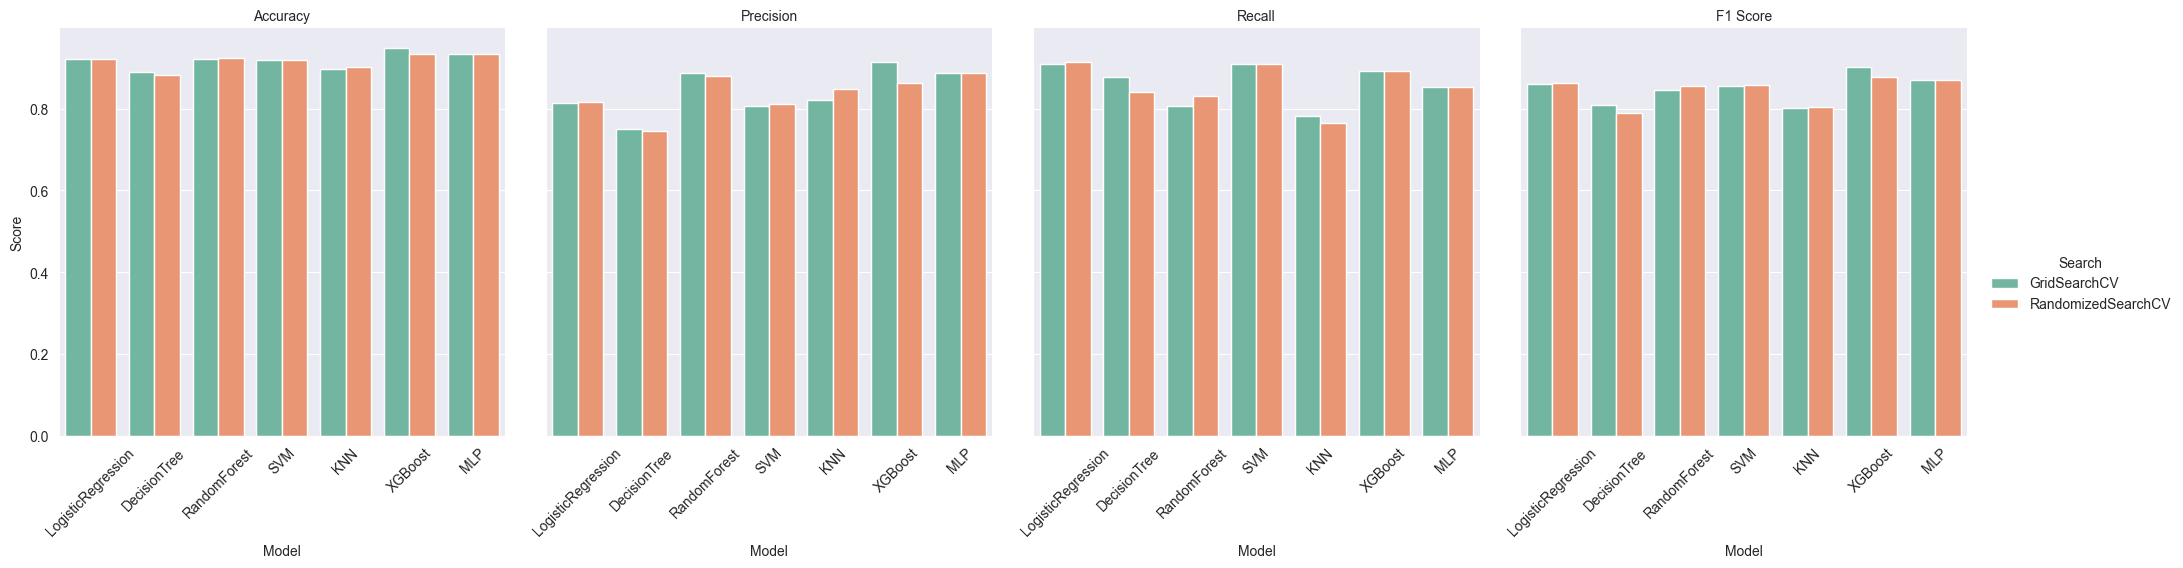

In [86]:
# 결과 정리
grid_df = pd.DataFrame(grid_results).T
grid_df['Search'] = 'GridSearchCV'

random_df = pd.DataFrame(random_results).T
random_df['Search'] = 'RandomizedSearchCV'

# 하나로 합치기
result_df = pd.concat([grid_df, random_df])
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'Model'}, inplace=True)

# 보기 좋게 정렬
result_df = result_df[['Model', 'Search', 'Best Params', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
display(result_df)
# 시각화를 위한 melt
melted = result_df.melt(id_vars=['Model', 'Search'],
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                        var_name='Metric', value_name='Score')

g = sns.catplot(data=melted, x='Model', y='Score', hue='Search', col='Metric',
                kind='bar', palette='Set2', height=5, aspect=1)
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)
plt.show()

In [90]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

# GridSearchCV 최적 파라미터 기반 VotingClassifier
voting_clf_grid = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=1, solver='saga', max_iter=1000, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(n_estimators=100, max_depth=3, scale_pos_weight=neg/pos, eval_metric='logloss', random_state=42))
    ],
    voting='soft'
)

# 학습
voting_clf_grid.fit(X_train_scaled_df, y_train)

# 예측
y_pred_grid = voting_clf_grid.predict(X_test_scaled_df)

results_grid = {
    'Model': 'VotingClassifier',
    'Search': 'GridSearchCV',
    'Best Params': "lr(C=1), rf(n_estimators=100, max_depth=None), xgb(n_estimators=100, max_depth=3)",
    'Accuracy': accuracy_score(y_test, y_pred_grid),
    'Precision': precision_score(y_test, y_pred_grid, zero_division=0),
    'Recall': recall_score(y_test, y_pred_grid),
    'F1 Score': f1_score(y_test, y_pred_grid)
}

# RandomizedSearchCV 최적 파라미터 기반 VotingClassifier
voting_clf_rand = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=2.0594494295802446, solver='saga', max_iter=1000, class_weight='balanced', random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=131, max_depth=18, class_weight='balanced', random_state=42)),
        ('xgb', XGBClassifier(
            n_estimators=100,
            max_depth=5,
            colsample_bytree=0.6677970986744369,
            learning_rate=0.1,
            scale_pos_weight=neg/pos,
            eval_metric='logloss',
            random_state=42))
    ],
    voting='soft'
)

# 학습
voting_clf_rand.fit(X_train_scaled_df, y_train)

# 예측
y_pred_rand = voting_clf_rand.predict(X_test_scaled_df)

# 결과 딕셔너리 생성
results_rand = {
    'Model': 'VotingClassifier',
    'Search': 'RandomizedSearchCV',
    'Best Params': "lr(C=2.059), rf(n_estimators=131, max_depth=18), xgb(... colsample_bytree=0.668 ...)",
    'Accuracy': accuracy_score(y_test, y_pred_rand),
    'Precision': precision_score(y_test, y_pred_rand, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rand),
    'F1 Score': f1_score(y_test, y_pred_rand)
}

In [91]:
# 기존 result_df에 VotingClassifier 추가
result_df = pd.concat([result_df, pd.DataFrame([results_grid, results_rand])], ignore_index=True)
result_df = result_df[['Model', 'Search', 'Best Params', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
display(result_df)

,Model,Search,Best Params,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,GridSearchCV,{'C': 1},0.92125,0.814346,0.910377,0.859688
1,DecisionTree,GridSearchCV,"{'max_depth': 5, 'min_samples_split': 5}",0.89,0.75,0.877358,0.808696
2,RandomForest,GridSearchCV,"{'max_depth': None, 'n_estimators': 100}",0.92125,0.88601,0.806604,0.844444
3,SVM,GridSearchCV,"{'C': 1, 'kernel': 'linear'}",0.91875,0.807531,0.910377,0.855876
4,KNN,GridSearchCV,{'n_neighbors': 5},0.8975,0.821782,0.783019,0.801932
5,XGBoost,GridSearchCV,"{'max_depth': 3, 'n_estimators': 100, 'scale_p...",0.94875,0.913043,0.891509,0.902148
6,MLP,GridSearchCV,"{'alpha': 0.001, 'early_stopping': True, 'hidd...",0.9325,0.887255,0.853774,0.870192
7,LogisticRegression,RandomizedSearchCV,{'C': 2.0594494295802446},0.9225,0.815126,0.915094,0.862222
8,DecisionTree,RandomizedSearchCV,"{'max_depth': 10, 'min_samples_split': 5}",0.88125,0.74477,0.839623,0.789357
9,RandomForest,RandomizedSearchCV,"{'max_depth': 18, 'n_estimators': 131}",0.925,0.88,0.830189,0.854369


In [92]:
# 우선 지표들을 숫자로 변환
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score']:
    result_df[metric] = pd.to_numeric(result_df[metric], errors='coerce')

# 모델별로 Grid와 Random 중 성능이 더 좋은 걸 선택하는 함수
def select_best_by_metric(df, metric):
    best_rows = []
    for model in df['Model'].unique():
        subset = df[df['Model'] == model]
        best_row = subset.loc[subset[metric].idxmax()]
        best_rows.append(best_row)
    return pd.DataFrame(best_rows).sort_values(by=metric, ascending=False).reset_index(drop=True)

# 1. Accuracy 기준
print("🔹 Accuracy 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_accuracy_df = select_best_by_metric(result_df, 'Accuracy')
display(best_accuracy_df[['Model', 'Search', 'Accuracy', 'Best Params']])
print()

# 2. Precision 기준
print("🔹 Precision 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_precision_df = select_best_by_metric(result_df, 'Precision')
display(best_precision_df[['Model', 'Search', 'Precision', 'Best Params']])
print()

# 3. Recall 기준
print("🔹 Recall 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_recall_df = select_best_by_metric(result_df, 'Recall')
display(best_recall_df[['Model', 'Search', 'Recall', 'Best Params']])
print()

# 4. F1 Score 기준
print("🔹 F1 Score 기준으로 성능이 가장 좋은 결과 (내림차순):")
best_f1_df = select_best_by_metric(result_df, 'F1 Score')
display(best_f1_df[['Model', 'Search', 'F1 Score', 'Best Params']])

🔹 Accuracy 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,Accuracy,Best Params
0,XGBoost,GridSearchCV,0.94875,"{'max_depth': 3, 'n_estimators': 100, 'scale_p..."
1,VotingClassifier,GridSearchCV,0.93875,"lr(C=1), rf(n_estimators=100, max_depth=None),..."
2,MLP,GridSearchCV,0.93250,"{'alpha': 0.001, 'early_stopping': True, 'hidd..."
3,RandomForest,RandomizedSearchCV,0.92500,"{'max_depth': 18, 'n_estimators': 131}"
4,LogisticRegression,RandomizedSearchCV,0.92250,{'C': 2.0594494295802446}
5,SVM,RandomizedSearchCV,0.92000,"{'C': 2.4512552224777417, 'kernel': 'linear'}"
6,KNN,RandomizedSearchCV,0.90125,{'n_neighbors': 19}
7,DecisionTree,GridSearchCV,0.89000,"{'max_depth': 5, 'min_samples_split': 5}"



🔹 Precision 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,Precision,Best Params
0,XGBoost,GridSearchCV,0.913043,"{'max_depth': 3, 'n_estimators': 100, 'scale_p..."
1,MLP,GridSearchCV,0.887255,"{'alpha': 0.001, 'early_stopping': True, 'hidd..."
2,RandomForest,GridSearchCV,0.886010,"{'max_depth': None, 'n_estimators': 100}"
3,VotingClassifier,GridSearchCV,0.868778,"lr(C=1), rf(n_estimators=100, max_depth=None),..."
4,KNN,RandomizedSearchCV,0.848168,{'n_neighbors': 19}
5,LogisticRegression,RandomizedSearchCV,0.815126,{'C': 2.0594494295802446}
6,SVM,RandomizedSearchCV,0.810924,"{'C': 2.4512552224777417, 'kernel': 'linear'}"
7,DecisionTree,GridSearchCV,0.750000,"{'max_depth': 5, 'min_samples_split': 5}"



🔹 Recall 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,Recall,Best Params
0,LogisticRegression,RandomizedSearchCV,0.915094,{'C': 2.0594494295802446}
1,SVM,GridSearchCV,0.910377,"{'C': 1, 'kernel': 'linear'}"
2,VotingClassifier,GridSearchCV,0.905660,"lr(C=1), rf(n_estimators=100, max_depth=None),..."
3,XGBoost,GridSearchCV,0.891509,"{'max_depth': 3, 'n_estimators': 100, 'scale_p..."
4,DecisionTree,GridSearchCV,0.877358,"{'max_depth': 5, 'min_samples_split': 5}"
5,MLP,GridSearchCV,0.853774,"{'alpha': 0.001, 'early_stopping': True, 'hidd..."
6,RandomForest,RandomizedSearchCV,0.830189,"{'max_depth': 18, 'n_estimators': 131}"
7,KNN,GridSearchCV,0.783019,{'n_neighbors': 5}



🔹 F1 Score 기준으로 성능이 가장 좋은 결과 (내림차순):


,Model,Search,F1 Score,Best Params
0,XGBoost,GridSearchCV,0.902148,"{'max_depth': 3, 'n_estimators': 100, 'scale_p..."
1,VotingClassifier,GridSearchCV,0.886836,"lr(C=1), rf(n_estimators=100, max_depth=None),..."
2,MLP,GridSearchCV,0.870192,"{'alpha': 0.001, 'early_stopping': True, 'hidd..."
3,LogisticRegression,RandomizedSearchCV,0.862222,{'C': 2.0594494295802446}
4,SVM,RandomizedSearchCV,0.857778,"{'C': 2.4512552224777417, 'kernel': 'linear'}"
5,RandomForest,RandomizedSearchCV,0.854369,"{'max_depth': 18, 'n_estimators': 131}"
6,DecisionTree,GridSearchCV,0.808696,"{'max_depth': 5, 'min_samples_split': 5}"
7,KNN,RandomizedSearchCV,0.803970,{'n_neighbors': 19}


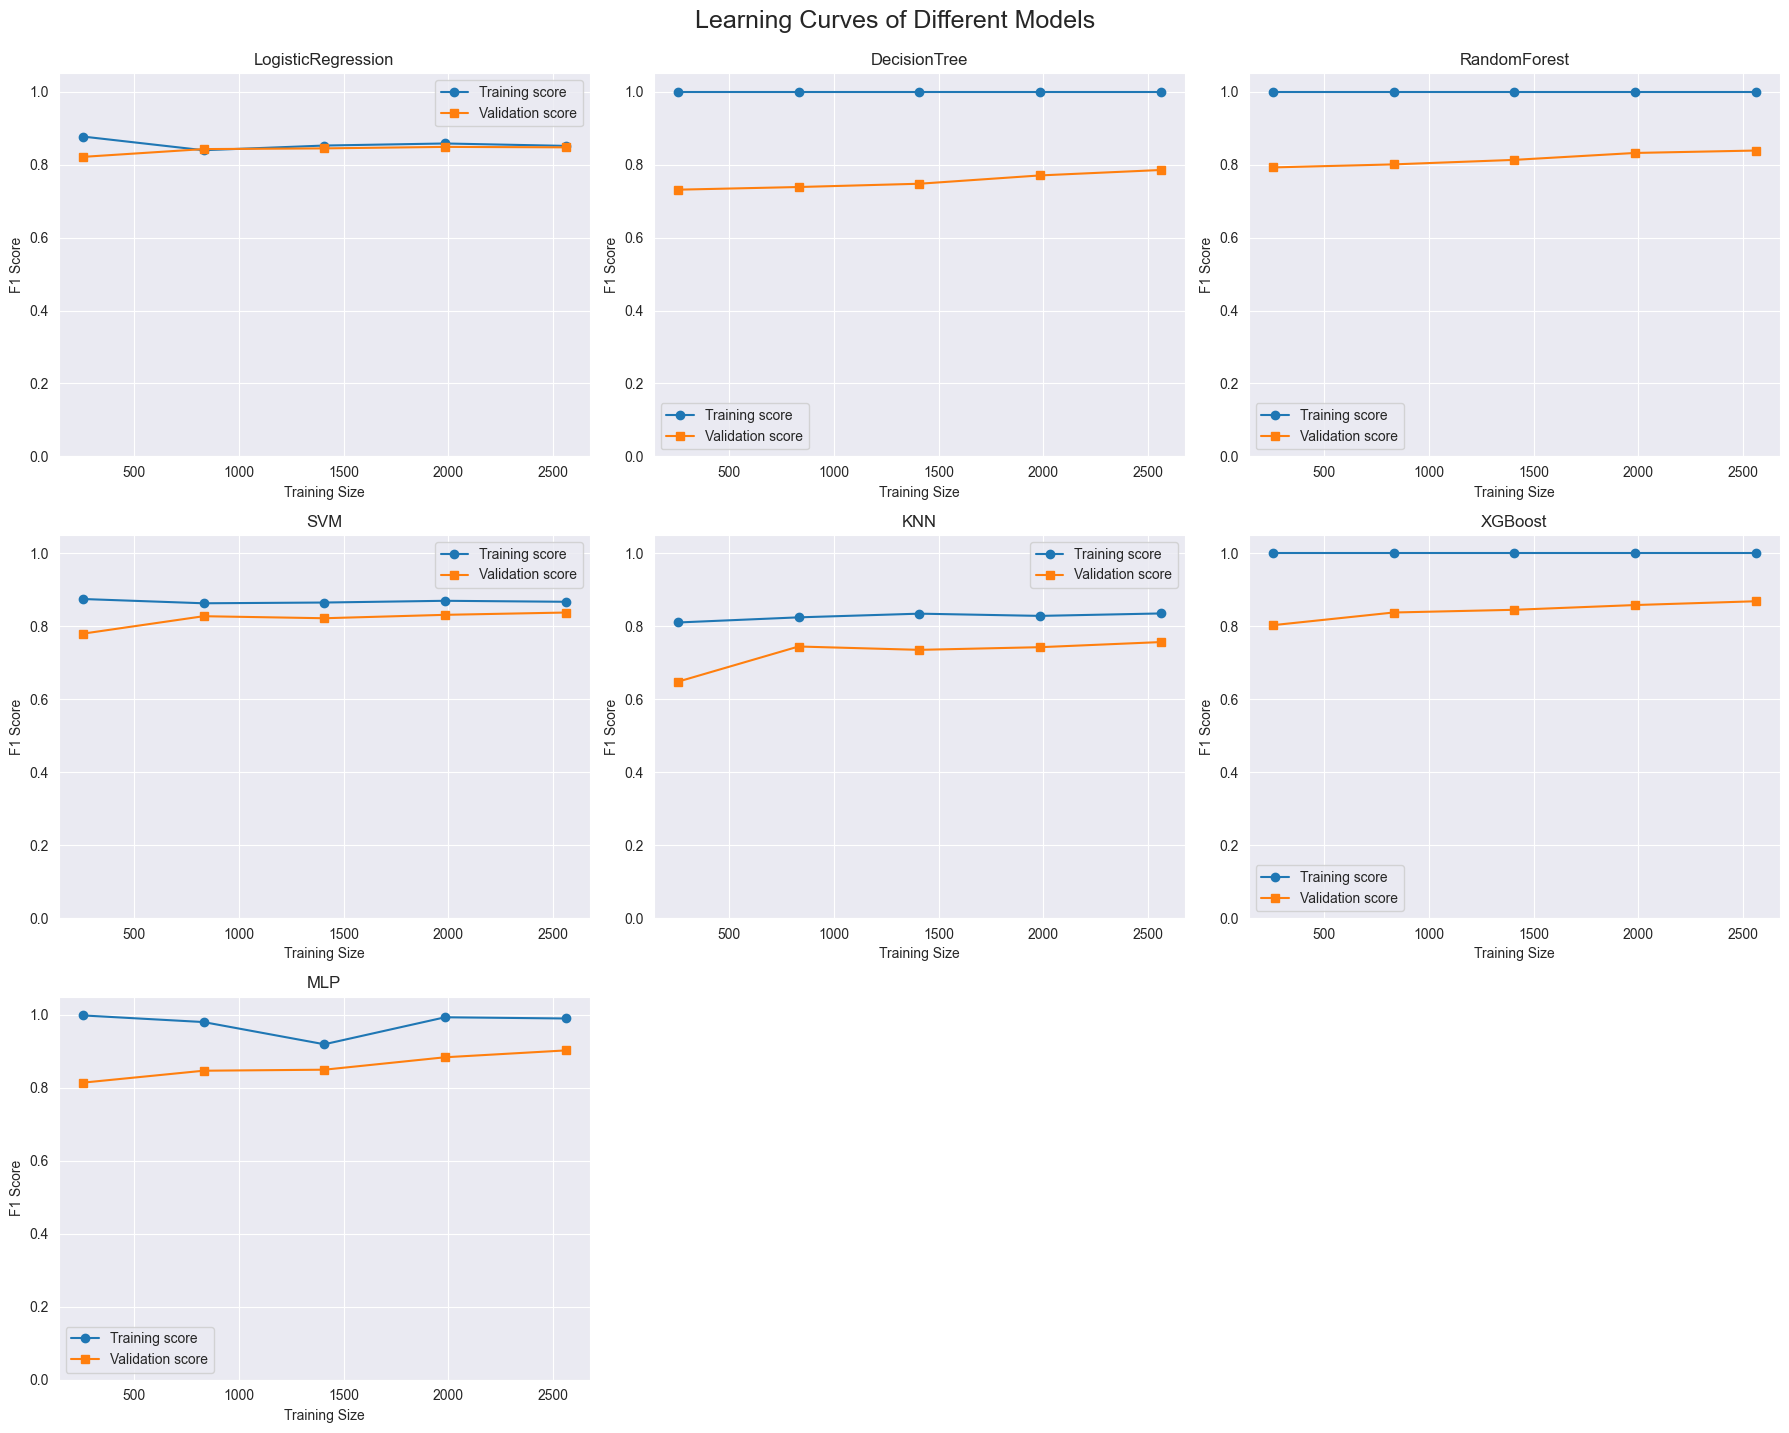

In [93]:
from sklearn.model_selection import learning_curve

# subplot 구성
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.ravel()

# 학습 곡선 그리기
for i, (name, model) in enumerate(models.items()):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_scaled, y_train, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    axes[i].plot(train_sizes, train_mean, label='Training score', marker='o')
    axes[i].plot(train_sizes, val_mean, label='Validation score', marker='s')
    axes[i].set_title(f'{name}')
    axes[i].set_xlabel('Training Size')
    axes[i].set_ylabel('F1 Score')
    axes[i].set_ylim(0.0, 1.05)
    axes[i].legend()
    axes[i].grid(True)

# 남은 subplot 비우기
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Learning Curves of Different Models", fontsize=18, y=1.02)
plt.show()

In [1]:
!pip install --upgrade matplotlib streamlit

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 50.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.1
    Uninstalling matplotlib-3.10.1:


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'c:\\users\\playdata\\miniconda3\\envs\\ai_basic_env\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

